<center>
    <img src="https://cdn.pixabay.com/photo/2015/04/23/22/00/tree-736885_960_720.jpg" width="800" alt="cognitiveclass.ai logo"  />
</center>

# Hourly load forecasting



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
energy=pd.read_csv("energy_dataset.csv")
weather=pd.read_csv("weather_features.csv")

In [3]:
energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17,NaN,6436,26118,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16,NaN,5856,24934,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8,NaN,5454,23515,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2,NaN,5151,22642,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9,NaN,4861,21785,20264.0,38.41,56.04


In [4]:
energy_df=energy.loc[:,['time','total load actual']]

In [5]:
energy_df.head()

,time,total load actual
0,2015-01-01 00:00:00+01:00,25385.0
1,2015-01-01 01:00:00+01:00,24382.0
2,2015-01-01 02:00:00+01:00,22734.0
3,2015-01-01 03:00:00+01:00,21286.0
4,2015-01-01 04:00:00+01:00,20264.0


In [6]:
energy_df.isna().sum()

time                  0
total load actual    36
dtype: int64

In [7]:
energy_df.interpolate(method='linear',limit_direction='forward',inplace=True)

In [8]:
energy_df['time']=pd.to_datetime(energy['time'])

In [9]:
energy_df.set_index('time',inplace=True)

(array([392709, 394464, 403224, 412008, 420768, 429528, 431279],
       dtype=int64),
 <a list of 7 Text xticklabel objects>)

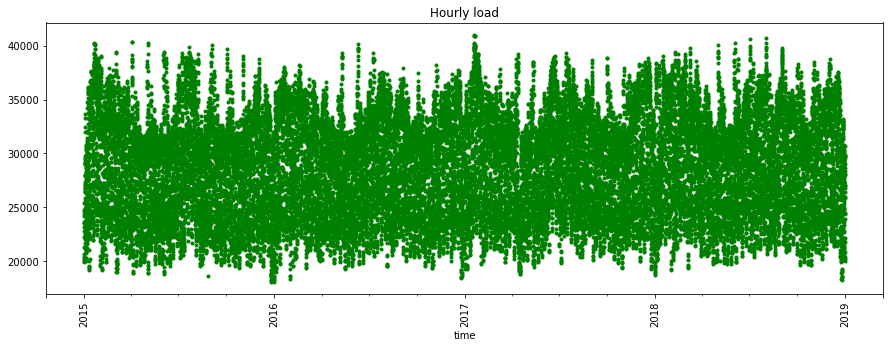

In [10]:
energy_df['total load actual'].plot(style='.', figsize=(15,5), title='Hourly load',color='g');
plt.xticks(rotation=90)

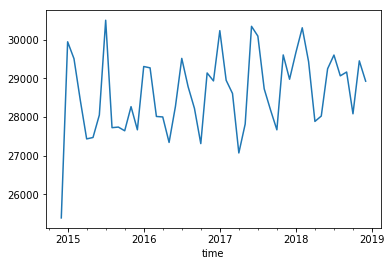

In [11]:
energy_df['total load actual'].resample('M').mean().plot()

In [12]:
energy_df.index

DatetimeIndex(['2014-12-31 23:00:00', '2015-01-01 00:00:00',
               '2015-01-01 01:00:00', '2015-01-01 02:00:00',
               '2015-01-01 03:00:00', '2015-01-01 04:00:00',
               '2015-01-01 05:00:00', '2015-01-01 06:00:00',
               '2015-01-01 07:00:00', '2015-01-01 08:00:00',
               ...
               '2018-12-31 13:00:00', '2018-12-31 14:00:00',
               '2018-12-31 15:00:00', '2018-12-31 16:00:00',
               '2018-12-31 17:00:00', '2018-12-31 18:00:00',
               '2018-12-31 19:00:00', '2018-12-31 20:00:00',
               '2018-12-31 21:00:00', '2018-12-31 22:00:00'],
              dtype='datetime64[ns]', name='time', length=35064, freq=None)

In [13]:
split_date = '2018-01-01 01:00:00+01:00'
df_train = energy_df.loc[energy_df.index <= split_date].copy()
df_test = energy_df.loc[energy_df.index > split_date].copy()

(array([392709, 394464, 403224, 412008, 420768, 429528, 431279],
       dtype=int64),
 <a list of 7 Text xticklabel objects>)

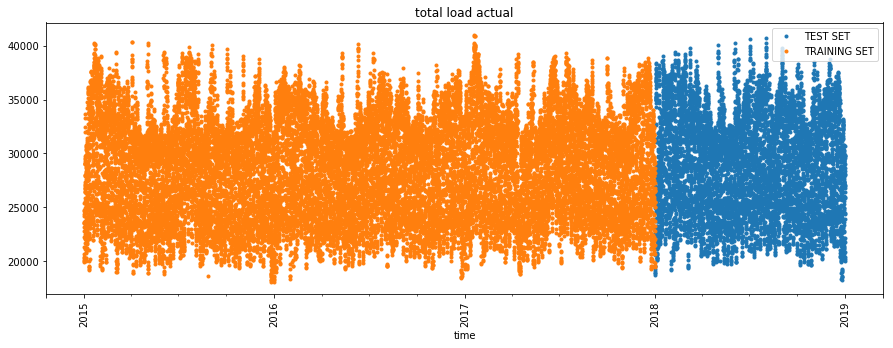

In [14]:
df_test \
    .rename(columns={'total load actual': 'TEST SET'}) \
    .join(df_train.rename(columns={'total load actual': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='total load actual', style='.');
plt.xticks(rotation=90)

## Features Engineering

In [15]:
# Create features from datetime index
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour', 'dayofweek','month', 'quarter', 'year', 'dayofyear',
            'dayofmonth', 'weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X
    

In [16]:
X_train, y_train = create_features(df_train, label='total load actual')
X_test, y_test = create_features(df_test, label='total load actual')

##  Build XGBoost Model

In [17]:

from xgboost import XGBRegressor
reg = XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds = 50,
        verbose = False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
       gamma=0, gpu_id=-1, importance_type=None,
       interaction_constraints='', learning_rate=0.300000012,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
       monotone_constraints='()', n_estimators=1000, n_jobs=8,
       num_parallel_tree=1, objective='reg:squarederror', predictor='auto',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       subsample=1, tree_method='exact', validate_parameters=1,
       verbosity=None)

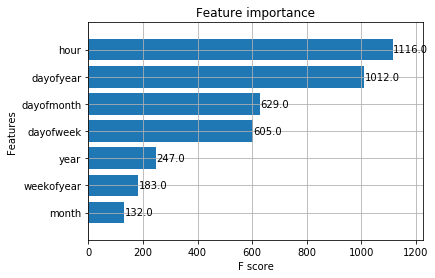

In [18]:

from xgboost import plot_importance, plot_tree
plot_importance(reg, height=0.8);

## Forecast on Test Set

In [19]:
df_test1=df_test.copy()
df_train1=df_train.copy()

In [20]:
df_test1['MW_Prediction'] = reg.predict(X_test)

In [21]:
df_test1.head()

,total load actual,date,hour,dayofweek,month,quarter,year,dayofyear,dayofmonth,weekofyear,MW_Prediction
time,,,,,,,,,,,
2018-01-01 01:00:00,20589.0,2018-01-01 01:00:00,1,0,1,1,2018,1,1,1,21598.820312
2018-01-01 02:00:00,19547.0,2018-01-01 02:00:00,2,0,1,1,2018,1,1,1,21391.060547
2018-01-01 03:00:00,18871.0,2018-01-01 03:00:00,3,0,1,1,2018,1,1,1,21391.060547
2018-01-01 04:00:00,18688.0,2018-01-01 04:00:00,4,0,1,1,2018,1,1,1,21080.166016
2018-01-01 05:00:00,18869.0,2018-01-01 05:00:00,5,0,1,1,2018,1,1,1,23010.320312


In [22]:
df_all = pd.concat([df_test1, df_train1], sort = False)

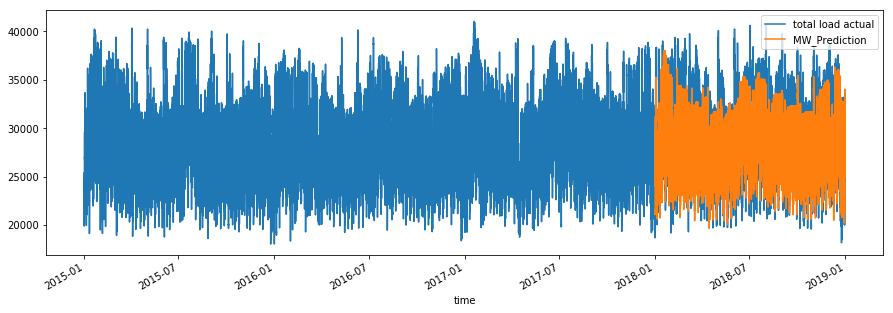

In [23]:
df_all[['total load actual', 'MW_Prediction']].plot(figsize=(15,5));

In [24]:
# Make predictions using the training and testing set
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

In [26]:
# The MAPE (Mean Absolute Percent Error) measures the size of the error
# in percentage terms.
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [27]:
print('R^2   train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

print('MSE   train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))

print('RMSE  train: %.2f, test: %.2f' %
      (np.sqrt(mean_squared_error(y_train, y_train_pred)),
       np.sqrt(mean_squared_error(y_test, y_test_pred))))

print('MAE   train: %.2f, test: %.2f' %
      (mean_absolute_error(y_train, y_train_pred),
       mean_absolute_error(y_test, y_test_pred)))

print('MAPE  train: %.2f, test: %.2f' %
      (mean_absolute_percentage_error(y_train, y_train_pred),
       mean_absolute_percentage_error(y_test, y_test_pred)))

R^2   train: 0.85, test: 0.75
MSE   train: 3043188.70, test: 5397958.50
RMSE  train: 1744.47, test: 2323.35
MAE   train: 1248.96, test: 1709.89
MAPE  train: 4.39, test: 5.84


The Mean absolute percent accuracy (MAPA) is 94.16% (100 - 5.84)

## Random forest Regressor

In [28]:
from sklearn.ensemble import RandomForestRegressor

In [29]:
from sklearn.model_selection import RandomizedSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [30]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
Average Error: 1808.9570 degrees.
Accuracy = 93.90%.


In [31]:
df_test1['rf_MW_Prediction_1']=base_model.predict(X_test)

In [32]:
df_all_1 = pd.concat([df_test1, df_train1], sort = False)

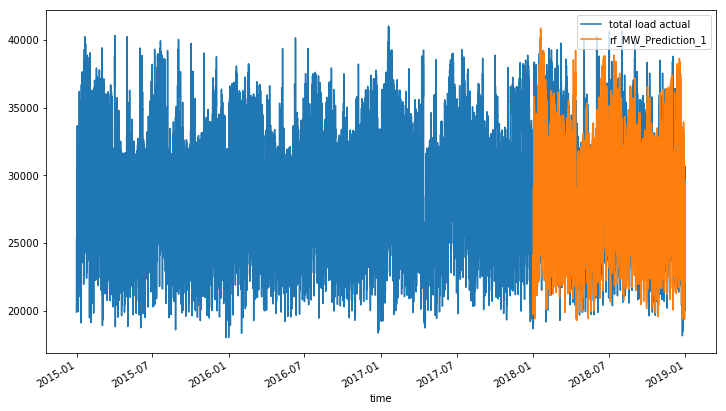

In [33]:
df_all_1[['total load actual', 'rf_MW_Prediction_1']].plot(figsize=(12,7))

In [34]:
# Make predictions using the training and testing set
y_train_pred = base_model.predict(X_train)
y_test_pred = base_model.predict(X_test)

In [35]:
print('R^2   train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

print('MSE   train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))

print('RMSE  train: %.2f, test: %.2f' %
      (np.sqrt(mean_squared_error(y_train, y_train_pred)),
       np.sqrt(mean_squared_error(y_test, y_test_pred))))

print('MAE   train: %.2f, test: %.2f' %
      (mean_absolute_error(y_train, y_train_pred),
       mean_absolute_error(y_test, y_test_pred)))

print('MAPE  train: %.2f, test: %.2f' %
      (mean_absolute_percentage_error(y_train, y_train_pred),
       mean_absolute_percentage_error(y_test, y_test_pred)))

R^2   train: 0.99, test: 0.69
MSE   train: 173154.44, test: 6627676.48
RMSE  train: 416.12, test: 2574.43
MAE   train: 223.19, test: 1808.96
MAPE  train: 0.82, test: 6.10


The Mean absolute percent accuracy (MAPA) is 93.90% (100 - 6.10)

In [36]:
import xgboost
from sklearn import svm
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import r2_score,mean_squared_error

In [37]:

model_params = {
    'svr': {
        'model': svm.SVR(gamma='auto'),
        'params' : {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestRegressor(),
        'params' : {
            'n_estimators': [1,5,10]
        }
    },
    'Lasso' : {
        'model': Lasso(),
        'params': {'alpha':[1e-15,1e-10,1e-8,1e-5,1e-3,10,15,20,25,30]}
    },
    'Ridge': {
        'model': Ridge(),
        'params': {'alpha':[1e-15,1e-10,1e-8,1e-5,1e-3,10,15,20,25,30]}
    },
    'xgboost': {
        'model': xgboost.XGBRegressor(),
        'params': {
            "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
            "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
            "min_child_weight" : [ 1, 3, 5, 7 ],
            "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
            "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]}
    },
    'decision_tree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [2, 3, 5, 10, 20],
            'min_samples_leaf': [5, 10, 20, 50, 100]}
    },
    'BayesianRidge': {
        'model': BayesianRidge(),
        'params': {}
    },
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}
    }        
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
scores = []
predicted_data=my_dict = {"Name":[],"predicted":[]}

for model_name, mp in model_params.items():
    clf =  RandomizedSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train,y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        "rmse":np.sqrt(mean_squared_error(y_test,clf.predict(X_test))),
        "r2_score":r2_score(y_test, clf.predict(X_test))
    })
    predicted_data['Name'].append(model_name)
    predicted_data['predicted'].append(clf.predict(X_test))

    
df = pd.DataFrame(scores,columns=['model','best_score','best_params','rmse','r2_score'])
df

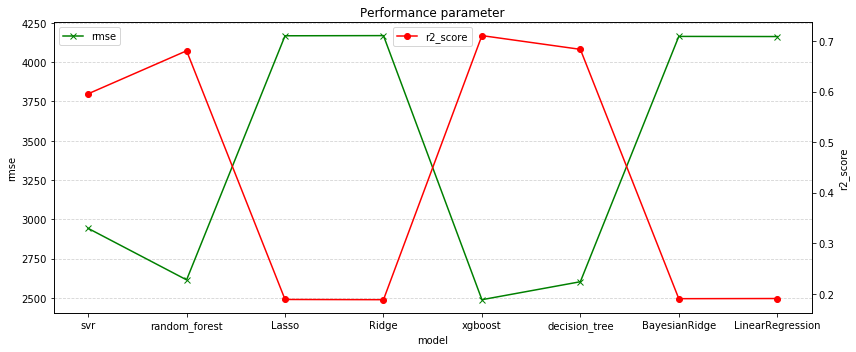

In [85]:

fig, ax = plt.subplots(figsize=(12,5))
ax2 = ax.twinx()
ax.set_title('Performance parameter',fontdict={'fontsize':20})
ax.set_xlabel('model')
ax.plot(df['model'],df['rmse'],color='green', marker='x')
ax2.plot(df['model'],df['r2_score'],color='red', marker='o')
ax.set_ylabel('rmse')
ax2.set_ylabel('r2_score')
ax.legend(['rmse'])
ax2.legend(['r2_score'], loc='upper center')
ax.yaxis.grid(color='lightgray', linestyle='dashed')
plt.tight_layout()
plt.show()

In [86]:
xyz=[]
for i in range(len(predicted_data['predicted'])):
    x=pd.Series(predicted_data['predicted'][i])
    xyz.append(x)
    

In [89]:
model_params.keys()

dict_keys(['svr', 'random_forest', 'Lasso', 'Ridge', 'xgboost', 'decision_tree', 'BayesianRidge', 'LinearRegression'])

In [87]:
y_predicted=(pd.DataFrame(xyz).transpose())
y_predicted.columns=list(model_params.keys())



In [101]:
y_predicted.head()

,svr,random_forest,Lasso,Ridge,xgboost,decision_tree,BayesianRidge,LinearRegression,y_test
time,,,,,,,,,
2018-01-01 01:00:00,25178.339739,20085.3,27885.566121,28124.059842,20677.384766,23331.596491,28223.004560,28247.146064,20589.0
2018-01-01 02:00:00,24861.235217,19989.1,28147.129690,28386.244878,19969.939453,23331.596491,28485.196373,28509.338613,19547.0
2018-01-01 03:00:00,25037.776693,19737.8,28408.693259,28648.429914,19604.814453,23331.596491,28747.388185,28771.531163,18871.0
2018-01-01 04:00:00,25858.662429,21177.1,28670.256828,28910.614949,19641.371094,23306.060000,29009.579998,29033.723713,18688.0
2018-01-01 05:00:00,27273.258178,23557.0,28931.820397,29172.799985,19906.142578,23833.095890,29271.771810,29295.916262,18869.0


In [90]:
y_predicted['y_test']=np.float64(y_test)

In [96]:
y_predicted.set_index(y_test.index,inplace=True)

In [97]:
y_predicted.head()

,svr,random_forest,Lasso,Ridge,xgboost,decision_tree,BayesianRidge,LinearRegression,y_test
time,,,,,,,,,
2018-01-01 01:00:00,25178.339739,20085.3,27885.566121,28124.059842,20677.384766,23331.596491,28223.004560,28247.146064,20589.0
2018-01-01 02:00:00,24861.235217,19989.1,28147.129690,28386.244878,19969.939453,23331.596491,28485.196373,28509.338613,19547.0
2018-01-01 03:00:00,25037.776693,19737.8,28408.693259,28648.429914,19604.814453,23331.596491,28747.388185,28771.531163,18871.0
2018-01-01 04:00:00,25858.662429,21177.1,28670.256828,28910.614949,19641.371094,23306.060000,29009.579998,29033.723713,18688.0
2018-01-01 05:00:00,27273.258178,23557.0,28931.820397,29172.799985,19906.142578,23833.095890,29271.771810,29295.916262,18869.0


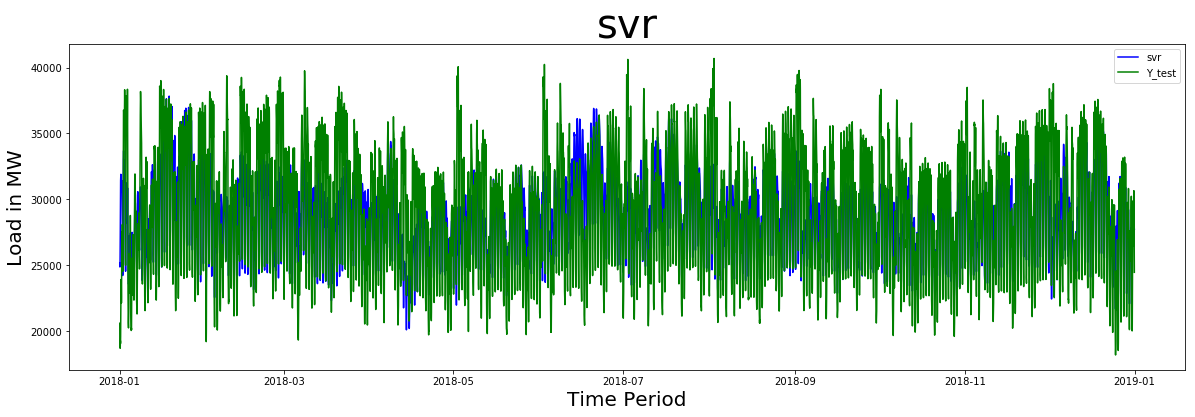

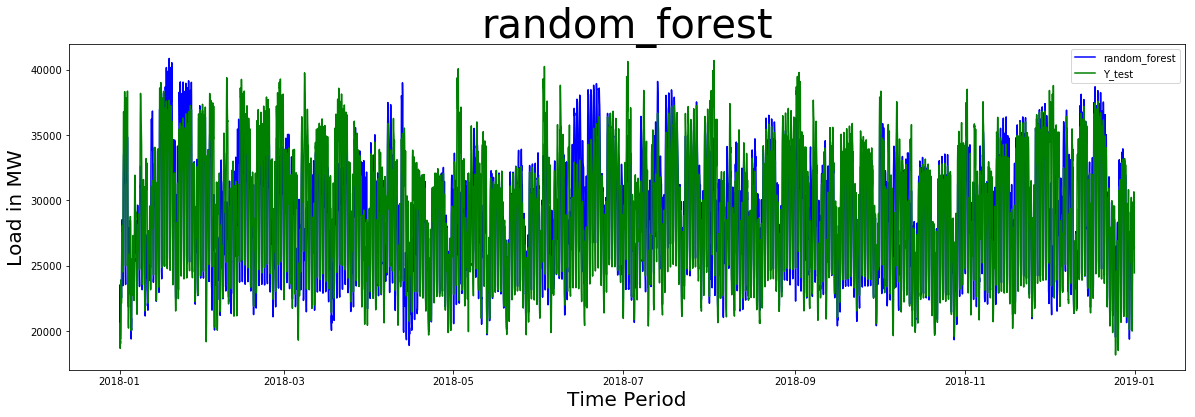

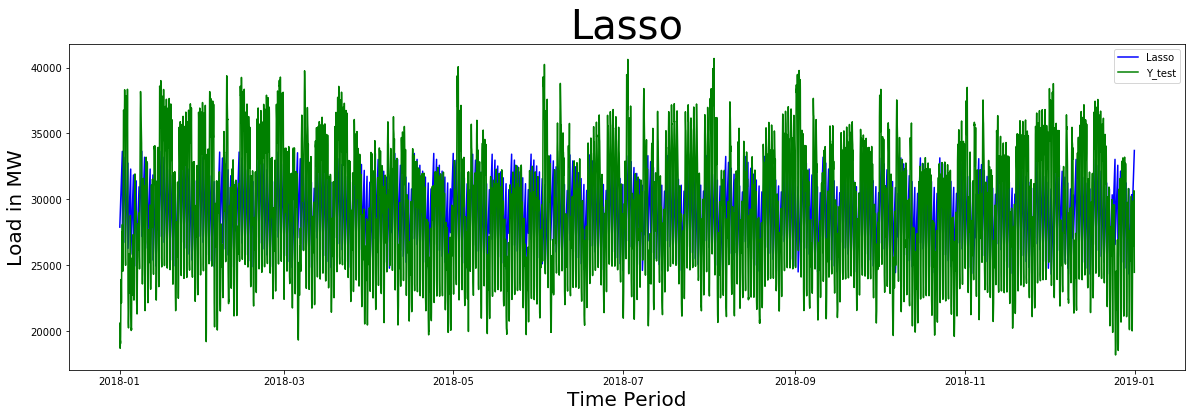

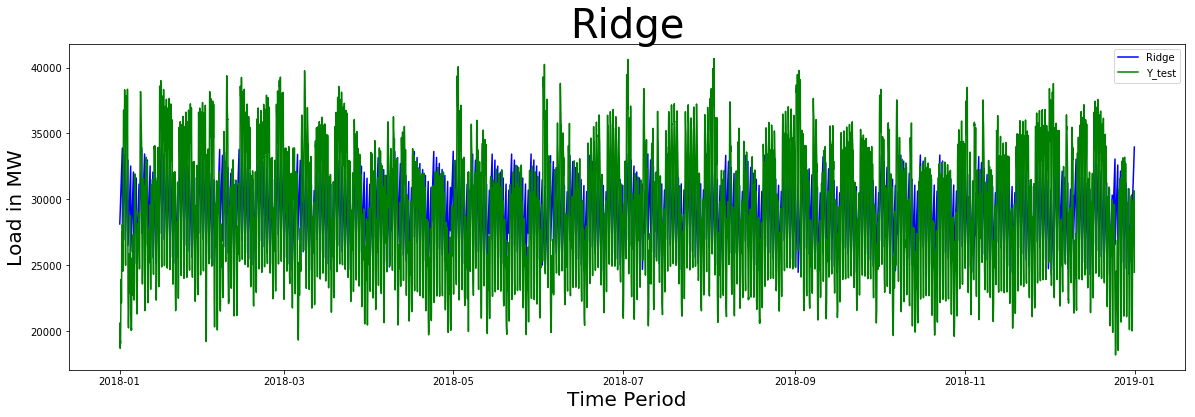

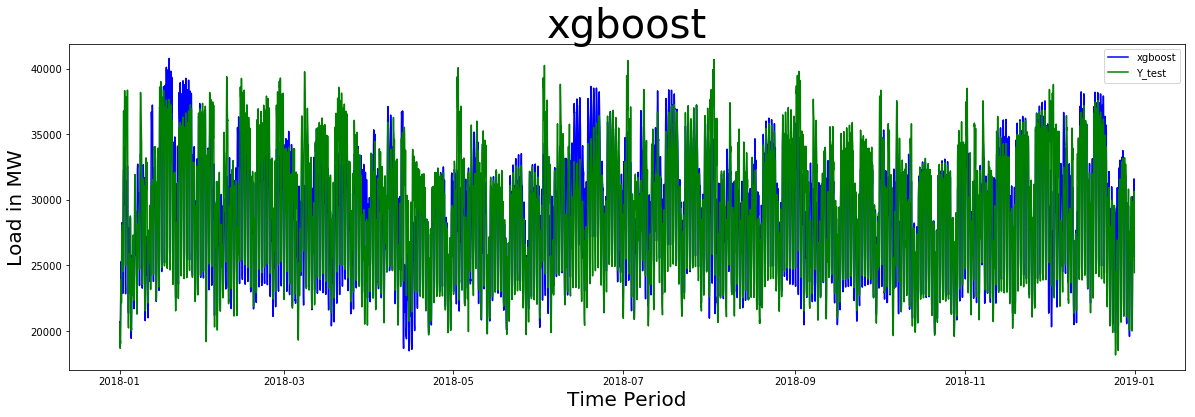

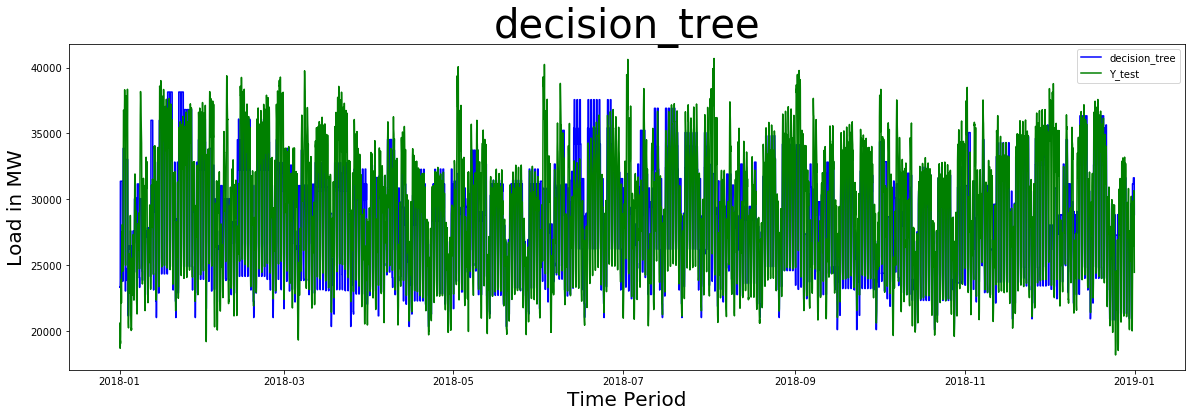

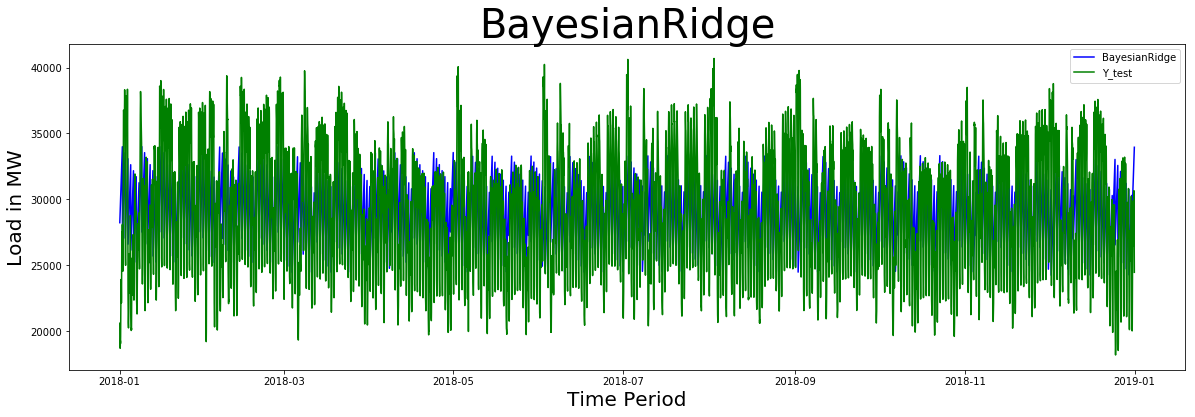

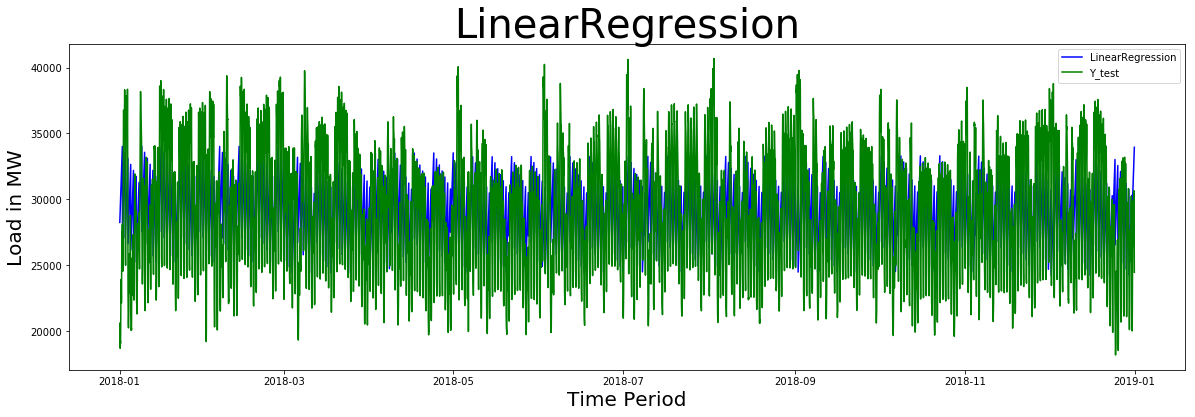

plotting completed


In [104]:

for i in y_predicted.columns:
    if i!='y_test':
        plt.figure(figsize=(20,6))
        plt.plot(y_predicted.index,y_predicted[i],color='blue')
        plt.plot(y_predicted.index,y_predicted['y_test'],color='g')
        plt.xlabel("Time Period",fontdict={'fontsize':20})
        plt.ylabel("Load in MW",fontdict={'fontsize':20})
        plt.title(i,fontdict={'fontsize':40})
        plt.legend([i,'Y_test'])
        plt.show()
    else:
        print("plotting completed")
    
    

In [106]:
X_test.tail()

,hour,dayofweek,month,quarter,year,dayofyear,dayofmonth,weekofyear
time,,,,,,,,
2018-12-31 18:00:00,18,0,12,4,2018,365,31,1
2018-12-31 19:00:00,19,0,12,4,2018,365,31,1
2018-12-31 20:00:00,20,0,12,4,2018,365,31,1
2018-12-31 21:00:00,21,0,12,4,2018,365,31,1
2018-12-31 22:00:00,22,0,12,4,2018,365,31,1
